<a href="https://colab.research.google.com/github/aSafarpoor/AI_Project_BypedalWalker/blob/master/ADA/classifier_part1_twitter_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

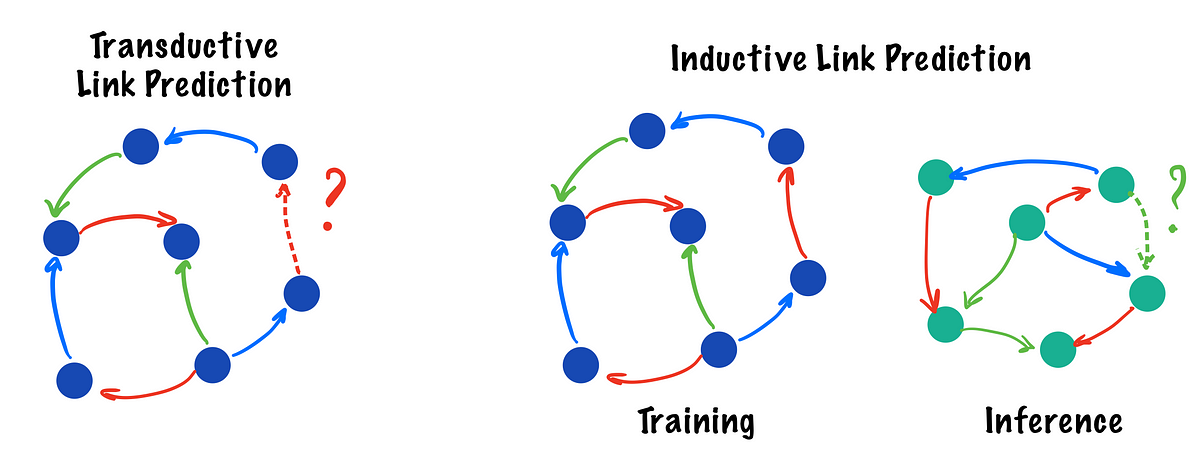

image ref:https://miro.medium.com/v2/resize:fit:1200/1*EA4KN94-dZzqQwkbAQ1R0g.png

#read data

In [1]:
import numpy as np
import random
from sklearn.metrics import confusion_matrix, accuracy_score
import networkx as nx
from tqdm import tqdm

In [2]:
def load_txt_file(filename):
	try:
		with open(filename, 'r') as file:
			return [int(line.strip()) for line in file]
	except:
		with open(filename, 'r') as file:
			first_line = file.readline().strip()  # Read only the first line
			return [int(num) for num in first_line.split()]

def load_txt_file_for_edges(filename):
	with open(filename, 'r') as file:
		return [list(map(int,line.strip().split())) for line in file]



In [3]:
def partitioner(x):
    midpoint = len(x) // 2

    # Split the list into two parts
    return x[:midpoint], x[midpoint:]

In [12]:
edges = load_txt_file_for_edges('edges.txt')

bknown = load_txt_file('btrain.txt')
sknown = load_txt_file('strain.txt')

b_known_in_test_phase,btrain = partitioner(bknown)
s_known_in_test_phase,strain = partitioner(sknown)


btest = load_txt_file('btest.txt')
stest = load_txt_file('stest.txt')
nodes = list(set(np.array(edges).reshape(-1)))
num_nodes = len(nodes)

print(len(btrain),len(sknown),len(btest),len(stest))

10000 10000 158377 81263


#Transductive

In [13]:
!pip install torch-geometric

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.7/63.7 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.9/241.9 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 124.6/124.6 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.1/318.1 kB 20.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.9/208.9 kB 15.8 MB/s eta 0:00:00


In [14]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
import torch_geometric.utils as pyg_utils
from torch_geometric.nn import GATConv
from sklearn.metrics import accuracy_score

from torch_geometric.utils import subgraph
from torch_geometric.nn import SAGEConv
# from torch_geometric.data import HeteroData

In [15]:
# it is not working because bias is false, I don't know why they set it false
class GCN_ETH(torch.nn.Module):
    def __init__(self, num_node_features, num_layers, hidden_width, dropout = True):
        super(GCN_ETH,self).__init__()

        self.dropout = dropout
        self.convs = torch.nn.ModuleList()
        input_width = num_node_features
        self.num_classes = 2
        for i in range(num_layers):
            if i == 0:
                self.convs.append(GCNConv(input_width, hidden_width, bias=False))
            elif i == num_layers - 1:
                self.convs.append(GCNConv(hidden_width, self.num_classes, bias=False))
            else:
                self.convs.append(GCNConv(hidden_width, hidden_width, bias=False))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        h = x
        i = 0
        for conv in self.convs:
            if self.dropout:
                h = F.dropout(h, p=0.5, training=self.training)
            h = conv(h, edge_index)
            if i < len(self.convs) - 1:
                h = F.tanh(h)
            i += 1

        return F.log_softmax(h, dim=1)


In [16]:
class Edited_GCN_ETH(torch.nn.Module):
    def __init__(self, num_node_features, num_layers, hidden_width, dropout=True):
        super(Edited_GCN_ETH, self).__init__()

        self.dropout = dropout
        self.convs = torch.nn.ModuleList()
        input_width = num_node_features
        self.num_classes = 2  # Assuming binary classification

        for i in range(num_layers):
            if i == 0:
                self.convs.append(GCNConv(input_width, hidden_width, bias=True))
            elif i == num_layers - 1:
                self.convs.append(GCNConv(hidden_width, self.num_classes, bias=True))
            else:
                self.convs.append(GCNConv(hidden_width, hidden_width, bias=True))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        h = x

        for i, conv in enumerate(self.convs):
            h = conv(h, edge_index)

            if i < len(self.convs) - 1:  # Apply activation and dropout for all but last layer
                h = F.relu(h)
                if self.dropout:
                    h = F.dropout(h, p=0.5, training=self.training)

        return F.log_softmax(h, dim=1)

In [17]:
class GAT_ETH(torch.nn.Module):
    def __init__(self, input_width, num_layers, hidden_width, num_classes, num_heads, dropout: bool = True):
        super().__init__()
        self.dropout = dropout
        self.num_classes = num_classes
        self.convs = torch.nn.ModuleList()

        for i in range(num_layers):
            if i == 0:
                self.convs.append(GATConv(input_width, hidden_width, heads=num_heads))
            elif i == num_layers - 1:
                self.convs.append(GATConv(hidden_width * num_heads, self.num_classes, heads=1))
            else:
                self.convs.append(GATConv(hidden_width * num_heads, hidden_width, heads=num_heads))

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        h = x

        i = 0
        for conv in self.convs:
            if self.dropout:
                h = F.dropout(h, p=0.5, training=self.training)
            h = conv(h, edge_index)
            if i < len(self.convs) - 1:
                h = F.tanh(h)
                # h = F.elu(h)
            i += 1

        return F.log_softmax(h, dim=1)



In [18]:
class GCN1(torch.nn.Module):
    def __init__(self, num_node_features, hidden_dim, num_classes):
        super(GCN1, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, num_classes)


    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [19]:
class GraphSAGE(torch.nn.Module):
    def __init__(self, num_node_features, hidden_dim, num_classes):
        super(GraphSAGE, self).__init__()
        # Define two SAGEConv layers
        self.conv1 = SAGEConv(num_node_features, hidden_dim)
        self.conv2 = SAGEConv(hidden_dim, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        # First layer: Aggregate features from neighbors
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        # Second layer: Further aggregation and classification
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

In [20]:
class GCN2(torch.nn.Module):
    def __init__(self, num_node_features, hidden_dim1, hidden_dim2, num_classes):
        super(GCN2, self).__init__()
        self.conv1 = GCNConv(num_node_features, hidden_dim1)
        self.conv2 = GCNConv(hidden_dim1, hidden_dim2)
        self.conv3 = GCNConv(hidden_dim2, num_classes)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)

        x = self.conv2(x, edge_index)
        x = F.relu(x)

        x = self.conv3(x, edge_index)
        x = F.softmax(x,dim=1)
        return F.log_softmax(x, dim=1)


In [21]:
class GAT1(torch.nn.Module):
    def __init__(self, num_node_features, hidden_dim1, hidden_dim2, num_classes, num_heads=1):
        super(GAT1, self).__init__()
        self.gat1 = GATConv(num_node_features, hidden_dim1, heads=num_heads, concat=True)
        self.gat2 = GATConv(hidden_dim1 * num_heads, hidden_dim2, heads=num_heads, concat=True)
        self.gat3 = GATConv(hidden_dim2 * num_heads, num_classes, heads=1, concat=False)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.gat1(x, edge_index)
        x = F.relu(x)

        x = self.gat2(x, edge_index)
        x = F.relu(x)

        x = self.gat3(x, edge_index)

        return F.log_softmax(x, dim=1)



In [22]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(1, 16)
        self.conv2 = GCNConv(16, 2)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x



In [23]:
def main_transductive(model,epochs=100):

    edge_index = torch.tensor([[e[0] for e in edges], [e[1] for e in edges]], dtype=torch.long)  # Replace with actual edges

    temp = []
    s1 = set(btrain + btest)
    s2 = set(strain + stest)
    for i in tqdm(range(num_nodes)):
        tempval = 0 if i in s1  else 1 if i in s2 else -1
        temp.append(tempval)
    labels = torch.tensor(temp)



    x = torch.zeros((num_nodes, 1))  # 1-dimensional embeddings, all zeros initially

    for node in btrain:
        x[node] = 0  # Benign training nodes
    for node in strain:
        x[node] = 1  # Sybil training nodes
    for node in btest + stest:
        x[node] = 0.5  # Test nodes

    data_train = Data(x=x, edge_index=edge_index, y=labels)


    for node in b_known_in_test_phase:
        x[node] = 0
    for node in s_known_in_test_phase:
        x[node] = 1


    data_test = Data(x=x, edge_index=edge_index, y=labels)


    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Split data into training and testing masks
    train_mask = torch.zeros(num_nodes, dtype=torch.bool)
    test_mask = torch.zeros(num_nodes, dtype=torch.bool)

    # Assign masks for training and testing nodes
    train_mask[btrain + strain] = True
    test_mask[btest + stest] = True

    # Training loop
    def train():
        model.train()
        optimizer.zero_grad()
        out = model(data_train)
        loss = loss_fn(out[train_mask], data_train.y[train_mask])  # Only consider training nodes for loss
        loss.backward()
        optimizer.step()
        return loss.item()

    # Testing function
    def test():
        model.eval()
        out = model(data_test)
        pred = out.argmax(dim=1)  # Get predictions
        train_acc = accuracy_score(data_test.y[train_mask].cpu(), pred[train_mask].cpu())
        test_acc = accuracy_score(data_test.y[test_mask].cpu(), pred[test_mask].cpu())
        return train_acc, test_acc
    print("y")

    # Training the model
    for epoch in tqdm(range(epochs)):
        loss = train()
        train_acc, test_acc = test()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

    # Final evaluation
    train_acc, test_acc = test()
    print(f'Final Train Accuracy: {train_acc:.4f}, Final Test Accuracy: {test_acc:.4f}')


In [25]:
main_transductive(Edited_GCN_ETH(num_node_features=1, num_layers=3, hidden_width=16),epochs=400)

100%|██████████| 269640/269640 [00:00<00:00, 2581392.94it/s]


y


  0%|          | 1/400 [00:02<19:15,  2.90s/it]

Epoch 0, Loss: 0.7056, Train Acc: 0.5238, Test Acc: 0.4244


  3%|▎         | 11/400 [00:29<17:01,  2.63s/it]

Epoch 10, Loss: 0.6459, Train Acc: 0.6667, Test Acc: 0.6609


  5%|▌         | 21/400 [00:57<17:20,  2.75s/it]

Epoch 20, Loss: 0.6188, Train Acc: 0.6667, Test Acc: 0.6609


  8%|▊         | 31/400 [01:23<16:37,  2.70s/it]

Epoch 30, Loss: 0.5810, Train Acc: 0.6667, Test Acc: 0.6608


 10%|█         | 41/400 [01:51<16:55,  2.83s/it]

Epoch 40, Loss: 0.5412, Train Acc: 0.7237, Test Acc: 0.6610


 13%|█▎        | 51/400 [02:20<16:58,  2.92s/it]

Epoch 50, Loss: 0.5101, Train Acc: 0.7358, Test Acc: 0.6634


 15%|█▌        | 61/400 [02:48<16:04,  2.85s/it]

Epoch 60, Loss: 0.4996, Train Acc: 0.7373, Test Acc: 0.6639


 18%|█▊        | 71/400 [03:17<16:00,  2.92s/it]

Epoch 70, Loss: 0.4941, Train Acc: 0.7306, Test Acc: 0.6617


 20%|██        | 81/400 [03:46<15:28,  2.91s/it]

Epoch 80, Loss: 0.4864, Train Acc: 0.7331, Test Acc: 0.6623


 23%|██▎       | 91/400 [04:15<14:51,  2.88s/it]

Epoch 90, Loss: 0.4857, Train Acc: 0.7371, Test Acc: 0.6637


 25%|██▌       | 101/400 [04:40<12:45,  2.56s/it]

Epoch 100, Loss: 0.4651, Train Acc: 0.7395, Test Acc: 0.6644


 28%|██▊       | 111/400 [05:06<12:09,  2.52s/it]

Epoch 110, Loss: 0.4582, Train Acc: 0.7379, Test Acc: 0.6637


 30%|███       | 121/400 [05:31<11:51,  2.55s/it]

Epoch 120, Loss: 0.4489, Train Acc: 0.7411, Test Acc: 0.6639


 33%|███▎      | 131/400 [05:59<12:14,  2.73s/it]

Epoch 130, Loss: 0.4333, Train Acc: 0.7635, Test Acc: 0.6663


 35%|███▌      | 141/400 [06:28<12:30,  2.90s/it]

Epoch 140, Loss: 0.4022, Train Acc: 0.7771, Test Acc: 0.6725


 38%|███▊      | 151/400 [06:56<11:55,  2.88s/it]

Epoch 150, Loss: 0.3752, Train Acc: 0.8135, Test Acc: 0.6936


 40%|████      | 161/400 [07:25<11:16,  2.83s/it]

Epoch 160, Loss: 0.3611, Train Acc: 0.8511, Test Acc: 0.7129


 43%|████▎     | 171/400 [07:52<10:22,  2.72s/it]

Epoch 170, Loss: 0.3452, Train Acc: 0.8503, Test Acc: 0.7126


 45%|████▌     | 181/400 [08:19<09:50,  2.70s/it]

Epoch 180, Loss: 0.3377, Train Acc: 0.8616, Test Acc: 0.7179


 48%|████▊     | 191/400 [08:46<09:37,  2.76s/it]

Epoch 190, Loss: 0.3323, Train Acc: 0.8694, Test Acc: 0.7181


 50%|█████     | 201/400 [09:14<09:35,  2.89s/it]

Epoch 200, Loss: 0.3207, Train Acc: 0.8759, Test Acc: 0.7144


 53%|█████▎    | 211/400 [09:43<08:50,  2.81s/it]

Epoch 210, Loss: 0.3140, Train Acc: 0.8802, Test Acc: 0.7112


 55%|█████▌    | 221/400 [10:11<08:30,  2.85s/it]

Epoch 220, Loss: 0.3224, Train Acc: 0.8837, Test Acc: 0.7093


 58%|█████▊    | 231/400 [10:40<08:04,  2.87s/it]

Epoch 230, Loss: 0.3154, Train Acc: 0.8869, Test Acc: 0.7084


 60%|██████    | 241/400 [11:09<07:26,  2.81s/it]

Epoch 240, Loss: 0.3167, Train Acc: 0.8835, Test Acc: 0.7144


 63%|██████▎   | 251/400 [11:37<06:53,  2.78s/it]

Epoch 250, Loss: 0.3139, Train Acc: 0.8849, Test Acc: 0.7148


 65%|██████▌   | 261/400 [12:06<06:44,  2.91s/it]

Epoch 260, Loss: 0.3098, Train Acc: 0.8834, Test Acc: 0.7165


 68%|██████▊   | 271/400 [12:34<06:00,  2.80s/it]

Epoch 270, Loss: 0.3069, Train Acc: 0.8829, Test Acc: 0.7176


 70%|███████   | 281/400 [13:02<05:42,  2.88s/it]

Epoch 280, Loss: 0.3076, Train Acc: 0.8894, Test Acc: 0.7128


 73%|███████▎  | 291/400 [13:31<05:12,  2.86s/it]

Epoch 290, Loss: 0.3056, Train Acc: 0.8902, Test Acc: 0.7133


 75%|███████▌  | 301/400 [14:01<04:48,  2.91s/it]

Epoch 300, Loss: 0.3041, Train Acc: 0.8911, Test Acc: 0.7123


 78%|███████▊  | 311/400 [14:29<04:12,  2.84s/it]

Epoch 310, Loss: 0.3043, Train Acc: 0.8920, Test Acc: 0.7137


 80%|████████  | 321/400 [14:58<03:58,  3.01s/it]

Epoch 320, Loss: 0.3032, Train Acc: 0.8956, Test Acc: 0.7118


 83%|████████▎ | 331/400 [15:27<03:17,  2.86s/it]

Epoch 330, Loss: 0.3051, Train Acc: 0.8957, Test Acc: 0.7124


 85%|████████▌ | 341/400 [15:56<02:52,  2.93s/it]

Epoch 340, Loss: 0.2987, Train Acc: 0.8929, Test Acc: 0.7149


 88%|████████▊ | 351/400 [16:23<02:11,  2.67s/it]

Epoch 350, Loss: 0.2972, Train Acc: 0.8974, Test Acc: 0.7110


 90%|█████████ | 361/400 [16:51<01:49,  2.81s/it]

Epoch 360, Loss: 0.2968, Train Acc: 0.8957, Test Acc: 0.7140


 93%|█████████▎| 371/400 [17:19<01:19,  2.74s/it]

Epoch 370, Loss: 0.3011, Train Acc: 0.8950, Test Acc: 0.7147


 95%|█████████▌| 381/400 [17:46<00:53,  2.82s/it]

Epoch 380, Loss: 0.2934, Train Acc: 0.8958, Test Acc: 0.7148


 98%|█████████▊| 391/400 [18:14<00:25,  2.79s/it]

Epoch 390, Loss: 0.3008, Train Acc: 0.8971, Test Acc: 0.7140


100%|██████████| 400/400 [18:40<00:00,  2.80s/it]


Final Train Accuracy: 0.8987, Final Test Accuracy: 0.7118


In [26]:
main_transductive(Edited_GCN_ETH(num_node_features=1, num_layers=3, hidden_width=4),epochs=400)

100%|██████████| 269640/269640 [00:00<00:00, 2354090.44it/s]


y


  0%|          | 1/400 [00:02<13:46,  2.07s/it]

Epoch 0, Loss: 0.6872, Train Acc: 0.6667, Test Acc: 0.6609


  3%|▎         | 11/400 [00:23<13:44,  2.12s/it]

Epoch 10, Loss: 0.6559, Train Acc: 0.6667, Test Acc: 0.6609


  5%|▌         | 21/400 [00:44<13:20,  2.11s/it]

Epoch 20, Loss: 0.6362, Train Acc: 0.6667, Test Acc: 0.6609


  8%|▊         | 31/400 [01:05<12:56,  2.11s/it]

Epoch 30, Loss: 0.6275, Train Acc: 0.6667, Test Acc: 0.6609


 10%|█         | 41/400 [01:26<12:39,  2.11s/it]

Epoch 40, Loss: 0.6207, Train Acc: 0.6667, Test Acc: 0.6609


 13%|█▎        | 51/400 [01:47<12:20,  2.12s/it]

Epoch 50, Loss: 0.6128, Train Acc: 0.6661, Test Acc: 0.6610


 15%|█▌        | 61/400 [02:09<12:00,  2.13s/it]

Epoch 60, Loss: 0.6084, Train Acc: 0.6667, Test Acc: 0.6608


 18%|█▊        | 71/400 [02:30<11:37,  2.12s/it]

Epoch 70, Loss: 0.6031, Train Acc: 0.7231, Test Acc: 0.6607


 20%|██        | 81/400 [02:51<11:26,  2.15s/it]

Epoch 80, Loss: 0.6047, Train Acc: 0.7241, Test Acc: 0.6608


 23%|██▎       | 91/400 [03:13<11:14,  2.18s/it]

Epoch 90, Loss: 0.5931, Train Acc: 0.7257, Test Acc: 0.6609


 25%|██▌       | 101/400 [03:35<10:50,  2.18s/it]

Epoch 100, Loss: 0.5894, Train Acc: 0.7284, Test Acc: 0.6611


 28%|██▊       | 111/400 [03:57<10:27,  2.17s/it]

Epoch 110, Loss: 0.5804, Train Acc: 0.7315, Test Acc: 0.6619


 30%|███       | 121/400 [04:18<09:39,  2.08s/it]

Epoch 120, Loss: 0.5864, Train Acc: 0.7319, Test Acc: 0.6619


 33%|███▎      | 131/400 [04:38<08:57,  2.00s/it]

Epoch 130, Loss: 0.5760, Train Acc: 0.7326, Test Acc: 0.6623


 35%|███▌      | 141/400 [04:58<08:40,  2.01s/it]

Epoch 140, Loss: 0.5736, Train Acc: 0.7321, Test Acc: 0.6619


 38%|███▊      | 151/400 [05:18<08:16,  1.99s/it]

Epoch 150, Loss: 0.5821, Train Acc: 0.7333, Test Acc: 0.6624


 40%|████      | 161/400 [05:38<07:52,  1.98s/it]

Epoch 160, Loss: 0.5736, Train Acc: 0.7357, Test Acc: 0.6632


 43%|████▎     | 171/400 [05:58<07:36,  1.99s/it]

Epoch 170, Loss: 0.5670, Train Acc: 0.7364, Test Acc: 0.6636


 45%|████▌     | 181/400 [06:18<07:13,  1.98s/it]

Epoch 180, Loss: 0.5676, Train Acc: 0.7362, Test Acc: 0.6632


 48%|████▊     | 191/400 [06:38<07:07,  2.05s/it]

Epoch 190, Loss: 0.5703, Train Acc: 0.7331, Test Acc: 0.6623


 50%|█████     | 201/400 [06:59<06:42,  2.02s/it]

Epoch 200, Loss: 0.5678, Train Acc: 0.7354, Test Acc: 0.6630


 53%|█████▎    | 211/400 [07:19<06:25,  2.04s/it]

Epoch 210, Loss: 0.5671, Train Acc: 0.7355, Test Acc: 0.6631


 55%|█████▌    | 221/400 [07:40<06:09,  2.07s/it]

Epoch 220, Loss: 0.5655, Train Acc: 0.7351, Test Acc: 0.6629


 58%|█████▊    | 231/400 [08:00<05:47,  2.06s/it]

Epoch 230, Loss: 0.5658, Train Acc: 0.7368, Test Acc: 0.6641


 60%|██████    | 241/400 [08:21<05:26,  2.05s/it]

Epoch 240, Loss: 0.5666, Train Acc: 0.7347, Test Acc: 0.6629


 63%|██████▎   | 251/400 [08:41<05:08,  2.07s/it]

Epoch 250, Loss: 0.5703, Train Acc: 0.7351, Test Acc: 0.6629


 65%|██████▌   | 261/400 [09:02<04:45,  2.05s/it]

Epoch 260, Loss: 0.5644, Train Acc: 0.7387, Test Acc: 0.6646


 68%|██████▊   | 271/400 [09:22<04:25,  2.06s/it]

Epoch 270, Loss: 0.5674, Train Acc: 0.7383, Test Acc: 0.6644


 70%|███████   | 281/400 [09:43<04:04,  2.05s/it]

Epoch 280, Loss: 0.5675, Train Acc: 0.7395, Test Acc: 0.6650


 73%|███████▎  | 291/400 [10:03<03:42,  2.04s/it]

Epoch 290, Loss: 0.5648, Train Acc: 0.7381, Test Acc: 0.6640


 75%|███████▌  | 301/400 [10:24<03:27,  2.10s/it]

Epoch 300, Loss: 0.5661, Train Acc: 0.7373, Test Acc: 0.6636


 78%|███████▊  | 311/400 [10:45<03:02,  2.05s/it]

Epoch 310, Loss: 0.5712, Train Acc: 0.7379, Test Acc: 0.6637


 80%|████████  | 321/400 [11:05<02:43,  2.07s/it]

Epoch 320, Loss: 0.5714, Train Acc: 0.7376, Test Acc: 0.6637


 83%|████████▎ | 331/400 [11:26<02:22,  2.07s/it]

Epoch 330, Loss: 0.5700, Train Acc: 0.7363, Test Acc: 0.6631


 85%|████████▌ | 341/400 [11:47<02:01,  2.05s/it]

Epoch 340, Loss: 0.5580, Train Acc: 0.7375, Test Acc: 0.6637


 88%|████████▊ | 351/400 [12:08<01:43,  2.11s/it]

Epoch 350, Loss: 0.5679, Train Acc: 0.7387, Test Acc: 0.6643


 90%|█████████ | 361/400 [12:29<01:23,  2.14s/it]

Epoch 360, Loss: 0.5654, Train Acc: 0.7392, Test Acc: 0.6645


 93%|█████████▎| 371/400 [12:51<01:02,  2.15s/it]

Epoch 370, Loss: 0.5661, Train Acc: 0.7403, Test Acc: 0.6650


 95%|█████████▌| 381/400 [13:12<00:40,  2.13s/it]

Epoch 380, Loss: 0.5627, Train Acc: 0.7413, Test Acc: 0.6656


 98%|█████████▊| 391/400 [13:34<00:19,  2.14s/it]

Epoch 390, Loss: 0.5524, Train Acc: 0.7438, Test Acc: 0.6663


100%|██████████| 400/400 [13:53<00:00,  2.08s/it]


Final Train Accuracy: 0.7456, Final Test Accuracy: 0.6671


In [27]:
main_transductive(GCN())

100%|██████████| 269640/269640 [00:00<00:00, 2436577.64it/s]


y


  1%|          | 1/100 [00:01<02:39,  1.61s/it]

Epoch 0, Loss: 0.7022, Train Acc: 0.4763, Test Acc: 0.3408


 11%|█         | 11/100 [00:19<02:35,  1.75s/it]

Epoch 10, Loss: 0.6568, Train Acc: 0.6667, Test Acc: 0.6609


 21%|██        | 21/100 [00:35<02:09,  1.64s/it]

Epoch 20, Loss: 0.6354, Train Acc: 0.6667, Test Acc: 0.6609


 31%|███       | 31/100 [00:52<01:54,  1.66s/it]

Epoch 30, Loss: 0.6072, Train Acc: 0.6669, Test Acc: 0.6609


 41%|████      | 41/100 [01:08<01:36,  1.64s/it]

Epoch 40, Loss: 0.5692, Train Acc: 0.7299, Test Acc: 0.6651


 51%|█████     | 51/100 [01:25<01:20,  1.64s/it]

Epoch 50, Loss: 0.5232, Train Acc: 0.7535, Test Acc: 0.6676


 61%|██████    | 61/100 [01:42<01:08,  1.77s/it]

Epoch 60, Loss: 0.4820, Train Acc: 0.7687, Test Acc: 0.6693


 71%|███████   | 71/100 [01:59<00:51,  1.78s/it]

Epoch 70, Loss: 0.4581, Train Acc: 0.7794, Test Acc: 0.6743


 81%|████████  | 81/100 [02:17<00:33,  1.77s/it]

Epoch 80, Loss: 0.4426, Train Acc: 0.7956, Test Acc: 0.6758


 91%|█████████ | 91/100 [02:35<00:15,  1.77s/it]

Epoch 90, Loss: 0.4287, Train Acc: 0.8151, Test Acc: 0.6837


100%|██████████| 100/100 [02:51<00:00,  1.71s/it]


Final Train Accuracy: 0.8263, Final Test Accuracy: 0.6821


In [28]:
main_transductive(GCN1(num_node_features=1, hidden_dim=4, num_classes=2))

100%|██████████| 269640/269640 [00:00<00:00, 2561630.39it/s]


y


  1%|          | 1/100 [00:01<02:14,  1.36s/it]

Epoch 0, Loss: 0.7881, Train Acc: 0.3646, Test Acc: 0.3391


 11%|█         | 11/100 [00:14<02:00,  1.35s/it]

Epoch 10, Loss: 0.6854, Train Acc: 0.6345, Test Acc: 0.5131


 21%|██        | 21/100 [00:28<01:48,  1.37s/it]

Epoch 20, Loss: 0.6398, Train Acc: 0.7099, Test Acc: 0.6624


 31%|███       | 31/100 [00:42<01:35,  1.38s/it]

Epoch 30, Loss: 0.6242, Train Acc: 0.6665, Test Acc: 0.6631


 41%|████      | 41/100 [00:56<01:20,  1.37s/it]

Epoch 40, Loss: 0.6177, Train Acc: 0.6665, Test Acc: 0.6622


 51%|█████     | 51/100 [01:10<01:07,  1.38s/it]

Epoch 50, Loss: 0.6124, Train Acc: 0.6669, Test Acc: 0.6625


 61%|██████    | 61/100 [01:24<00:54,  1.40s/it]

Epoch 60, Loss: 0.6069, Train Acc: 0.6656, Test Acc: 0.6631


 71%|███████   | 71/100 [01:37<00:40,  1.39s/it]

Epoch 70, Loss: 0.6016, Train Acc: 0.6642, Test Acc: 0.6635


 81%|████████  | 81/100 [01:51<00:26,  1.39s/it]

Epoch 80, Loss: 0.5969, Train Acc: 0.7173, Test Acc: 0.6637


 91%|█████████ | 91/100 [02:05<00:12,  1.39s/it]

Epoch 90, Loss: 0.5925, Train Acc: 0.7157, Test Acc: 0.6637


100%|██████████| 100/100 [02:18<00:00,  1.38s/it]


Final Train Accuracy: 0.7142, Final Test Accuracy: 0.6636


In [29]:
main_transductive(GCN2(num_node_features=1, hidden_dim1=16, hidden_dim2 = 16, num_classes=2))

100%|██████████| 269640/269640 [00:00<00:00, 2404608.14it/s]


y


  1%|          | 1/100 [00:02<04:51,  2.95s/it]

Epoch 0, Loss: 0.6897, Train Acc: 0.6667, Test Acc: 0.6609


 11%|█         | 11/100 [00:32<04:19,  2.91s/it]

Epoch 10, Loss: 0.6570, Train Acc: 0.6667, Test Acc: 0.6609


 21%|██        | 21/100 [01:00<03:38,  2.77s/it]

Epoch 20, Loss: 0.6364, Train Acc: 0.6667, Test Acc: 0.6609


 31%|███       | 31/100 [01:28<03:13,  2.81s/it]

Epoch 30, Loss: 0.6053, Train Acc: 0.7228, Test Acc: 0.6608


 41%|████      | 41/100 [01:56<02:48,  2.86s/it]

Epoch 40, Loss: 0.5691, Train Acc: 0.7353, Test Acc: 0.6631


 51%|█████     | 51/100 [02:24<02:17,  2.80s/it]

Epoch 50, Loss: 0.5432, Train Acc: 0.7665, Test Acc: 0.6704


 61%|██████    | 61/100 [02:53<01:49,  2.80s/it]

Epoch 60, Loss: 0.5197, Train Acc: 0.7816, Test Acc: 0.6775


 71%|███████   | 71/100 [03:21<01:21,  2.82s/it]

Epoch 70, Loss: 0.4975, Train Acc: 0.8089, Test Acc: 0.6827


 81%|████████  | 81/100 [03:49<00:52,  2.79s/it]

Epoch 80, Loss: 0.4766, Train Acc: 0.8401, Test Acc: 0.6902


 91%|█████████ | 91/100 [04:17<00:25,  2.79s/it]

Epoch 90, Loss: 0.4568, Train Acc: 0.8663, Test Acc: 0.6943


100%|██████████| 100/100 [04:42<00:00,  2.82s/it]


Final Train Accuracy: 0.8822, Final Test Accuracy: 0.7018


In [30]:
main_transductive(GraphSAGE(num_node_features=1, hidden_dim=4, num_classes=2))

100%|██████████| 269640/269640 [00:00<00:00, 2421365.72it/s]


y


  1%|          | 1/100 [00:00<01:10,  1.40it/s]

Epoch 0, Loss: 0.7262, Train Acc: 0.5374, Test Acc: 0.6746


 11%|█         | 11/100 [00:08<01:05,  1.37it/s]

Epoch 10, Loss: 0.6556, Train Acc: 0.6667, Test Acc: 0.6609


 21%|██        | 21/100 [00:15<00:58,  1.34it/s]

Epoch 20, Loss: 0.5948, Train Acc: 0.6667, Test Acc: 0.6609


 31%|███       | 31/100 [00:22<00:51,  1.34it/s]

Epoch 30, Loss: 0.5248, Train Acc: 0.6667, Test Acc: 0.6609


 41%|████      | 41/100 [00:30<00:43,  1.35it/s]

Epoch 40, Loss: 0.4245, Train Acc: 0.8256, Test Acc: 0.6609


 51%|█████     | 51/100 [00:37<00:37,  1.31it/s]

Epoch 50, Loss: 0.3069, Train Acc: 0.9971, Test Acc: 0.6624


 61%|██████    | 61/100 [00:45<00:29,  1.34it/s]

Epoch 60, Loss: 0.2019, Train Acc: 0.9988, Test Acc: 0.6663


 71%|███████   | 71/100 [00:52<00:21,  1.33it/s]

Epoch 70, Loss: 0.1253, Train Acc: 0.9989, Test Acc: 0.6822


 81%|████████  | 81/100 [01:00<00:14,  1.34it/s]

Epoch 80, Loss: 0.0792, Train Acc: 0.9989, Test Acc: 0.6901


 91%|█████████ | 91/100 [01:07<00:06,  1.29it/s]

Epoch 90, Loss: 0.0530, Train Acc: 0.9989, Test Acc: 0.6898


100%|██████████| 100/100 [01:14<00:00,  1.34it/s]


Final Train Accuracy: 0.9989, Final Test Accuracy: 0.6927


In [31]:
main_transductive(GCN_ETH(num_node_features=1, num_layers=3, hidden_width=8))

100%|██████████| 269640/269640 [00:00<00:00, 2299416.95it/s]


y


  1%|          | 1/100 [00:02<04:05,  2.48s/it]

Epoch 0, Loss: 0.6987, Train Acc: 0.6667, Test Acc: 0.6609


 11%|█         | 11/100 [00:27<03:37,  2.44s/it]

Epoch 10, Loss: 0.6819, Train Acc: 0.6667, Test Acc: 0.6609


 21%|██        | 21/100 [00:51<03:12,  2.44s/it]

Epoch 20, Loss: 0.6784, Train Acc: 0.6667, Test Acc: 0.6609


 31%|███       | 31/100 [01:15<02:48,  2.44s/it]

Epoch 30, Loss: 0.6746, Train Acc: 0.6667, Test Acc: 0.6609


 41%|████      | 41/100 [01:41<02:29,  2.53s/it]

Epoch 40, Loss: 0.6711, Train Acc: 0.6667, Test Acc: 0.6609


 51%|█████     | 51/100 [02:06<02:02,  2.50s/it]

Epoch 50, Loss: 0.6694, Train Acc: 0.6667, Test Acc: 0.6609


 61%|██████    | 61/100 [02:31<01:38,  2.54s/it]

Epoch 60, Loss: 0.6623, Train Acc: 0.6667, Test Acc: 0.6609


 71%|███████   | 71/100 [02:56<01:12,  2.51s/it]

Epoch 70, Loss: 0.6592, Train Acc: 0.6667, Test Acc: 0.6609


 81%|████████  | 81/100 [03:21<00:47,  2.51s/it]

Epoch 80, Loss: 0.6556, Train Acc: 0.6667, Test Acc: 0.6609


 91%|█████████ | 91/100 [03:47<00:22,  2.52s/it]

Epoch 90, Loss: 0.6479, Train Acc: 0.6667, Test Acc: 0.6609


100%|██████████| 100/100 [04:09<00:00,  2.50s/it]


Final Train Accuracy: 0.6667, Final Test Accuracy: 0.6609


In [32]:
main_transductive(GAT1(num_node_features=1, hidden_dim1=4, hidden_dim2=4, num_classes=2, num_heads=4))

100%|██████████| 269640/269640 [00:00<00:00, 2446550.31it/s]


y


  1%|          | 1/100 [00:08<13:26,  8.14s/it]

Epoch 0, Loss: 0.6890, Train Acc: 0.6667, Test Acc: 0.6609


 11%|█         | 11/100 [01:25<11:26,  7.72s/it]

Epoch 10, Loss: 0.6502, Train Acc: 0.6667, Test Acc: 0.6609


 21%|██        | 21/100 [02:43<10:18,  7.84s/it]

Epoch 20, Loss: 0.6119, Train Acc: 0.6667, Test Acc: 0.6609


 31%|███       | 31/100 [04:02<08:57,  7.79s/it]

Epoch 30, Loss: 0.5421, Train Acc: 0.7254, Test Acc: 0.6607


 41%|████      | 41/100 [05:20<07:43,  7.85s/it]

Epoch 40, Loss: 0.4406, Train Acc: 0.7571, Test Acc: 0.6629


 51%|█████     | 51/100 [06:40<06:28,  7.93s/it]

Epoch 50, Loss: 0.3185, Train Acc: 0.9249, Test Acc: 0.7878


 61%|██████    | 61/100 [08:01<05:15,  8.10s/it]

Epoch 60, Loss: 0.2068, Train Acc: 0.9529, Test Acc: 0.8200


 71%|███████   | 71/100 [09:19<03:44,  7.74s/it]

Epoch 70, Loss: 0.1538, Train Acc: 0.9557, Test Acc: 0.8381


 81%|████████  | 81/100 [10:37<02:26,  7.72s/it]

Epoch 80, Loss: 0.1374, Train Acc: 0.9515, Test Acc: 0.8148


 91%|█████████ | 91/100 [11:56<01:12,  8.01s/it]

Epoch 90, Loss: 0.1322, Train Acc: 0.9562, Test Acc: 0.8370


100%|██████████| 100/100 [13:07<00:00,  7.88s/it]


Final Train Accuracy: 0.9555, Final Test Accuracy: 0.8385


In [33]:
main_transductive(GAT_ETH(input_width=1, num_layers=4, hidden_width=16, num_classes=2, num_heads=8, dropout= True))

100%|██████████| 269640/269640 [00:00<00:00, 2442001.90it/s]


y


  1%|          | 1/100 [00:26<43:47, 26.54s/it]

Epoch 0, Loss: 0.7524, Train Acc: 0.6667, Test Acc: 0.6609


 11%|█         | 11/100 [04:50<39:06, 26.37s/it]

Epoch 10, Loss: 0.6027, Train Acc: 0.7241, Test Acc: 0.6607


 21%|██        | 21/100 [09:18<35:15, 26.77s/it]

Epoch 20, Loss: 0.5946, Train Acc: 0.7249, Test Acc: 0.6607


 31%|███       | 31/100 [13:46<30:56, 26.91s/it]

Epoch 30, Loss: 0.5801, Train Acc: 0.7257, Test Acc: 0.6606


 41%|████      | 41/100 [18:14<26:29, 26.95s/it]

Epoch 40, Loss: 0.5649, Train Acc: 0.7301, Test Acc: 0.6606


 51%|█████     | 51/100 [22:42<21:38, 26.49s/it]

Epoch 50, Loss: 0.5000, Train Acc: 0.7551, Test Acc: 0.6631


 61%|██████    | 61/100 [27:11<17:28, 26.88s/it]

Epoch 60, Loss: 0.4185, Train Acc: 0.9381, Test Acc: 0.8219


 71%|███████   | 71/100 [31:40<12:59, 26.87s/it]

Epoch 70, Loss: 0.5067, Train Acc: 0.7440, Test Acc: 0.6626


 81%|████████  | 81/100 [36:09<08:30, 26.87s/it]

Epoch 80, Loss: 0.4493, Train Acc: 0.7450, Test Acc: 0.6627


 91%|█████████ | 91/100 [40:39<04:02, 26.99s/it]

Epoch 90, Loss: 0.4561, Train Acc: 0.7409, Test Acc: 0.6624


100%|██████████| 100/100 [44:42<00:00, 26.83s/it]


Final Train Accuracy: 0.7580, Final Test Accuracy: 0.6653


In [34]:
main_transductive(GAT1(num_node_features=1, hidden_dim1=4, hidden_dim2=4, num_classes=2, num_heads=8))

100%|██████████| 269640/269640 [00:00<00:00, 2374867.19it/s]


y


  1%|          | 1/100 [00:10<18:05, 10.96s/it]

Epoch 0, Loss: 0.7035, Train Acc: 0.6667, Test Acc: 0.6609


 11%|█         | 11/100 [01:58<16:00, 10.79s/it]

Epoch 10, Loss: 0.6347, Train Acc: 0.6667, Test Acc: 0.6609


 21%|██        | 21/100 [03:46<14:16, 10.84s/it]

Epoch 20, Loss: 0.5485, Train Acc: 0.7247, Test Acc: 0.6608


 31%|███       | 31/100 [05:36<12:37, 10.97s/it]

Epoch 30, Loss: 0.3899, Train Acc: 0.8467, Test Acc: 0.6937


 41%|████      | 41/100 [07:24<10:37, 10.81s/it]

Epoch 40, Loss: 0.2090, Train Acc: 0.9428, Test Acc: 0.7867


 51%|█████     | 51/100 [09:13<08:55, 10.93s/it]

Epoch 50, Loss: 0.1508, Train Acc: 0.9547, Test Acc: 0.7965


 61%|██████    | 61/100 [11:02<07:05, 10.91s/it]

Epoch 60, Loss: 0.1326, Train Acc: 0.9592, Test Acc: 0.8072


 71%|███████   | 71/100 [12:50<05:17, 10.93s/it]

Epoch 70, Loss: 0.1264, Train Acc: 0.9587, Test Acc: 0.8157


 81%|████████  | 81/100 [14:39<03:26, 10.85s/it]

Epoch 80, Loss: 0.1241, Train Acc: 0.9591, Test Acc: 0.8177


 91%|█████████ | 91/100 [16:28<01:37, 10.87s/it]

Epoch 90, Loss: 0.1224, Train Acc: 0.9607, Test Acc: 0.8174


100%|██████████| 100/100 [18:06<00:00, 10.87s/it]


Final Train Accuracy: 0.9615, Final Test Accuracy: 0.8195


In [35]:
main_transductive(GCN2(num_node_features=1, hidden_dim1=6, hidden_dim2 = 6, num_classes=2))

100%|██████████| 269640/269640 [00:00<00:00, 2459960.61it/s]


y


  1%|          | 1/100 [00:02<04:08,  2.51s/it]

Epoch 0, Loss: 0.6929, Train Acc: 0.6667, Test Acc: 0.6609


 11%|█         | 11/100 [00:26<03:36,  2.44s/it]

Epoch 10, Loss: 0.6723, Train Acc: 0.6667, Test Acc: 0.6609


 21%|██        | 21/100 [00:50<03:02,  2.31s/it]

Epoch 20, Loss: 0.6547, Train Acc: 0.6667, Test Acc: 0.6609


 31%|███       | 31/100 [01:13<02:39,  2.32s/it]

Epoch 30, Loss: 0.6467, Train Acc: 0.6667, Test Acc: 0.6609


 41%|████      | 41/100 [01:36<02:13,  2.27s/it]

Epoch 40, Loss: 0.6426, Train Acc: 0.6667, Test Acc: 0.6609


 51%|█████     | 51/100 [01:58<01:50,  2.26s/it]

Epoch 50, Loss: 0.6382, Train Acc: 0.6667, Test Acc: 0.6609


 61%|██████    | 61/100 [02:21<01:27,  2.25s/it]

Epoch 60, Loss: 0.6322, Train Acc: 0.6667, Test Acc: 0.6609


 71%|███████   | 71/100 [02:43<01:04,  2.24s/it]

Epoch 70, Loss: 0.6241, Train Acc: 0.6667, Test Acc: 0.6609


 81%|████████  | 81/100 [03:06<00:42,  2.23s/it]

Epoch 80, Loss: 0.6179, Train Acc: 0.6667, Test Acc: 0.6609


 91%|█████████ | 91/100 [03:28<00:20,  2.25s/it]

Epoch 90, Loss: 0.6110, Train Acc: 0.6667, Test Acc: 0.6609


100%|██████████| 100/100 [03:48<00:00,  2.29s/it]


Final Train Accuracy: 0.6667, Final Test Accuracy: 0.6609


#inductive

In [40]:
edges = load_txt_file_for_edges('edges.txt')

bknown = load_txt_file('btrain.txt')
sknown = load_txt_file('strain.txt')

b_known_in_test_phase,btrain = partitioner(bknown)
s_known_in_test_phase,strain = partitioner(sknown)


btest = load_txt_file('btest.txt')
stest = load_txt_file('stest.txt')
nodes = list(set(np.array(edges).reshape(-1)))
num_nodes = len(nodes)

print(len(btrain),len(sknown),len(btest),len(stest))

10000 10000 158377 81263


In [41]:
def remap_graph_and_update_lists(g, list1, list2):
    nodes = list(g.nodes())
    node_mapping = {old_node: new_index for new_index, old_node in enumerate(nodes)}

    g_mapped = nx.relabel_nodes(g, node_mapping)

    updated_list1 = [node_mapping[node] for node in list1 if node in node_mapping]
    updated_list2 = [node_mapping[node] for node in list2 if node in node_mapping]

    return g_mapped, updated_list1, updated_list2

#creat subgraphs
known_nodes = set(btrain + strain + btest + stest)
unknown_nodes = list(set(range(num_nodes)) - known_nodes)

# Sample 1/4 of unknown nodes for TRAIN
random.shuffle(unknown_nodes)
unknown_sample_for_train = unknown_nodes[:len(unknown_nodes)//4]
unknown_sample_for_test = list(set(unknown_nodes)-set(unknown_sample_for_train))

# Create subgraph TRAIN consisting of btrain, strain, and 1/4 of unknown nodes
train_nodes = btrain + strain + unknown_sample_for_train
test_nodes = btest + stest + unknown_sample_for_test


g = nx.Graph()
g.add_edges_from(edges)


gtrain = g.subgraph(train_nodes)
gtest = g.subgraph(test_nodes)


gtrain,btrain,strain = remap_graph_and_update_lists(gtrain,btrain,strain)
gtest,btest,stest = remap_graph_and_update_lists(gtest,btest,stest)

train_nodes = list(gtrain.nodes())
test_nodes = list(gtest.nodes())
# now we have to seperated graph.


# Create edge_index from edges
edges = list(gtrain.edges())
edge_index_train = torch.tensor([[e[0] for e in edges[:]], [e[1] for e in edges[:]]], dtype=torch.long)
edges = list(gtest.edges())
edge_index_test = torch.tensor([[e[0] for e in edges[:]], [e[1] for e in edges[:]]], dtype=torch.long)



# Assign labels (0 for benign, 1 for sybil)
labels_train = torch.tensor([0 if i in set(btrain) else 1 if i in set(strain) else -1 for i in range(len(gtrain.nodes()))], dtype=torch.long)
# labels_test = torch.tensor([0 if i in set(btest) else 1 if i in set(stest) else -1 for i in range(len(gtest.nodes()))], dtype=torch.long)



In [42]:
btest_set = set(btest)
stest_set = set(stest)

# Use list comprehension with tqdm and avoid repeated membership checks
labels_test = torch.tensor(
    [0 if i in btest_set else 1 if i in stest_set else -1 for i in tqdm(range(len(gtest.nodes())), desc="Generating labels")],
    dtype=torch.long
)

Generating labels: 100%|██████████| 250890/250890 [00:00<00:00, 2701497.53it/s]


In [50]:

def main_inductive(model,epochs = 100):


    # Initialize the node features
    x = torch.zeros((len(train_nodes), 1))  # 1-dimensional embeddings, all zeros initially
    for node in train_nodes:
        x[node] = 0.5  # Test nodes
    for node in btrain:
        x[node] = 0  # Benign training nodes
    for node in strain:
        x[node] = 1  # Sybil training nodes

    # Create the PyTorch Geometric data object for training
    data_train = Data(x=x, edge_index=edge_index_train, y=labels_train)


    # Create modified node features for test phase
    x = torch.zeros((len(test_nodes), 1))  # 1-dimensional embeddings, all zeros initially
    for node in test_nodes:
        x[node] = 0.5  # Test nodes
    for node in btrain:
        x[node] = 0  # Benign training nodes
    for node in strain:
        x[node] = 1  # Sybil training nodes

    # Create the PyTorch Geometric data object for testing
    data_test = Data(x=x, edge_index=edge_index_test, y=labels_test)

    # Define optimizer and loss function
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)
    loss_fn = torch.nn.CrossEntropyLoss()

    # Masks for training and testing
    train_mask = torch.zeros(len(gtrain.nodes()), dtype=torch.bool)
    test_mask = torch.zeros(len(gtest.nodes()), dtype=torch.bool)

    # Assign masks for training and testing nodes
    train_mask[btrain + strain] = True
    test_mask[btest + stest] = True

    # Training loop
    def train():
        model.train()
        optimizer.zero_grad()
        out = model(data_train)
        loss = loss_fn(out[train_mask], data_train.y[train_mask])  # Only consider training nodes for loss
        loss.backward()
        optimizer.step()
        return loss.item()

    # Testing function
    def test():
        model.eval()
        out = model(data_test)
        pred = out.argmax(dim=1)  # Get predictions
        test_acc = accuracy_score(data_test.y[test_mask].cpu(), pred[test_mask].cpu())
        out = model(data_train)
        pred = out.argmax(dim=1)
        train_acc = accuracy_score(data_train.y[train_mask].cpu(), pred[train_mask].cpu())

        return test_acc,train_acc

    # Training the model

    for epoch in range(epochs):
        loss = train()
        test_acc,train_acc = test()
        if epoch % 10 == 0:
            print(f'Epoch {epoch}, Loss: {loss:.4f}, Train Acc: {train_acc:.4f}, Test Acc: {test_acc:.4f}')

    # Final evaluation
    test_acc,train_acc = test()
    print(f'Final Train Accuracy: {train_acc:.4f}, Final Test Accuracy: {test_acc:.4f}')

In [51]:
main_inductive(GCN2(num_node_features=1, hidden_dim1=4, hidden_dim2 = 4, num_classes=2))

Epoch 0, Loss: 0.6906, Train Acc: 0.6013, Test Acc: 0.3384
Epoch 10, Loss: 0.6611, Train Acc: 0.8347, Test Acc: 0.6516
Epoch 20, Loss: 0.6228, Train Acc: 0.8425, Test Acc: 0.6541
Epoch 30, Loss: 0.5776, Train Acc: 0.8638, Test Acc: 0.6554
Epoch 40, Loss: 0.5298, Train Acc: 0.8642, Test Acc: 0.6601
Epoch 50, Loss: 0.4878, Train Acc: 0.8701, Test Acc: 0.6607
Epoch 60, Loss: 0.4581, Train Acc: 0.8723, Test Acc: 0.6607
Epoch 70, Loss: 0.4397, Train Acc: 0.8759, Test Acc: 0.6606
Epoch 80, Loss: 0.4279, Train Acc: 0.8962, Test Acc: 0.6605
Epoch 90, Loss: 0.4193, Train Acc: 0.9023, Test Acc: 0.6604
Final Train Accuracy: 0.9076, Final Test Accuracy: 0.6601


In [58]:
main_inductive(GAT1(num_node_features=1, hidden_dim1=4, hidden_dim2=4, num_classes=2, num_heads=2),epochs=400)

Epoch 0, Loss: 0.6966, Train Acc: 0.6667, Test Acc: 0.6609
Epoch 10, Loss: 0.6120, Train Acc: 0.6667, Test Acc: 0.6609
Epoch 20, Loss: 0.5404, Train Acc: 0.8236, Test Acc: 0.6609
Epoch 30, Loss: 0.4570, Train Acc: 0.8353, Test Acc: 0.6608
Epoch 40, Loss: 0.3673, Train Acc: 0.8651, Test Acc: 0.6587
Epoch 50, Loss: 0.2847, Train Acc: 0.9171, Test Acc: 0.6485
Epoch 60, Loss: 0.2247, Train Acc: 0.9303, Test Acc: 0.6656
Epoch 70, Loss: 0.1776, Train Acc: 0.9418, Test Acc: 0.4094
Epoch 80, Loss: 0.1370, Train Acc: 0.9531, Test Acc: 0.3637
Epoch 90, Loss: 0.1159, Train Acc: 0.9611, Test Acc: 0.3558
Epoch 100, Loss: 0.1056, Train Acc: 0.9660, Test Acc: 0.3517
Epoch 110, Loss: 0.1014, Train Acc: 0.9701, Test Acc: 0.3508
Epoch 120, Loss: 0.0983, Train Acc: 0.9714, Test Acc: 0.3518
Epoch 130, Loss: 0.0955, Train Acc: 0.9718, Test Acc: 0.3534
Epoch 140, Loss: 0.0930, Train Acc: 0.9729, Test Acc: 0.3550
Epoch 150, Loss: 0.0908, Train Acc: 0.9741, Test Acc: 0.3571
Epoch 160, Loss: 0.0887, Train Acc:

In [ ]:
main_inductive(GAT_ETH(input_width=1, num_layers=4, hidden_width=8, num_classes=2, num_heads=8, dropout= True),epochs=1000)

Epoch 0, Loss: 0.7054, Train Acc: 0.5475, Test Acc: 0.3392
Epoch 10, Loss: 0.6202, Train Acc: 0.8397, Test Acc: 0.6608
Epoch 20, Loss: 0.5526, Train Acc: 0.8237, Test Acc: 0.6609
Epoch 30, Loss: 0.5190, Train Acc: 0.8684, Test Acc: 0.6603
Epoch 40, Loss: 0.5491, Train Acc: 0.8273, Test Acc: 0.6609
Epoch 50, Loss: 0.5309, Train Acc: 0.8303, Test Acc: 0.6609
Epoch 60, Loss: 0.5350, Train Acc: 0.8293, Test Acc: 0.6609
Epoch 70, Loss: 0.5338, Train Acc: 0.8310, Test Acc: 0.6608
Epoch 80, Loss: 0.5340, Train Acc: 0.8247, Test Acc: 0.6609
Epoch 90, Loss: 0.5115, Train Acc: 0.8291, Test Acc: 0.6609
Epoch 100, Loss: 0.5050, Train Acc: 0.8239, Test Acc: 0.6609
Epoch 110, Loss: 0.4926, Train Acc: 0.8281, Test Acc: 0.6609
Epoch 120, Loss: 0.4687, Train Acc: 0.8265, Test Acc: 0.6609
Epoch 130, Loss: 0.4797, Train Acc: 0.8231, Test Acc: 0.6609
Epoch 140, Loss: 0.4820, Train Acc: 0.6667, Test Acc: 0.6609
Epoch 150, Loss: 0.5117, Train Acc: 0.8234, Test Acc: 0.6609
Epoch 160, Loss: 0.4992, Train Acc:

In [61]:
main_inductive(Edited_GCN_ETH(num_node_features=1, num_layers=2, hidden_width=4),epochs=300)

Epoch 0, Loss: 0.6702, Train Acc: 0.5789, Test Acc: 0.3392
Epoch 10, Loss: 0.6113, Train Acc: 0.8607, Test Acc: 0.6000
Epoch 20, Loss: 0.5610, Train Acc: 0.8957, Test Acc: 0.6358
Epoch 30, Loss: 0.5129, Train Acc: 0.8975, Test Acc: 0.6691
Epoch 40, Loss: 0.4726, Train Acc: 0.9046, Test Acc: 0.6718
Epoch 50, Loss: 0.4472, Train Acc: 0.9065, Test Acc: 0.6718
Epoch 60, Loss: 0.4233, Train Acc: 0.9107, Test Acc: 0.6793
Epoch 70, Loss: 0.3976, Train Acc: 0.9101, Test Acc: 0.6794
Epoch 80, Loss: 0.3901, Train Acc: 0.9103, Test Acc: 0.6795
Epoch 90, Loss: 0.3806, Train Acc: 0.9094, Test Acc: 0.6794
Epoch 100, Loss: 0.3606, Train Acc: 0.9089, Test Acc: 0.6776
Epoch 110, Loss: 0.3427, Train Acc: 0.9123, Test Acc: 0.6795
Epoch 120, Loss: 0.3375, Train Acc: 0.9114, Test Acc: 0.6788
Epoch 130, Loss: 0.3254, Train Acc: 0.9115, Test Acc: 0.6796
Epoch 140, Loss: 0.3264, Train Acc: 0.9116, Test Acc: 0.6796
Epoch 150, Loss: 0.3402, Train Acc: 0.9121, Test Acc: 0.6786
Epoch 160, Loss: 0.3323, Train Acc:

In [55]:
main_inductive(GraphSAGE(num_node_features=1, hidden_dim=8, num_classes=2))

Epoch 0, Loss: 1.0686, Train Acc: 0.3333, Test Acc: 0.3391
Epoch 10, Loss: 0.7707, Train Acc: 0.3333, Test Acc: 0.3391
Epoch 20, Loss: 0.5740, Train Acc: 1.0000, Test Acc: 0.6112
Epoch 30, Loss: 0.4157, Train Acc: 0.9989, Test Acc: 0.6218
Epoch 40, Loss: 0.2705, Train Acc: 1.0000, Test Acc: 0.6043
Epoch 50, Loss: 0.1588, Train Acc: 1.0000, Test Acc: 0.5251
Epoch 60, Loss: 0.0916, Train Acc: 1.0000, Test Acc: 0.5481
Epoch 70, Loss: 0.0546, Train Acc: 1.0000, Test Acc: 0.5034
Epoch 80, Loss: 0.0334, Train Acc: 1.0000, Test Acc: 0.5503
Epoch 90, Loss: 0.0209, Train Acc: 1.0000, Test Acc: 0.5589
Final Train Accuracy: 1.0000, Final Test Accuracy: 0.5583


In [56]:
main_inductive(Edited_GCN_ETH(num_node_features=1, num_layers=2, hidden_width=4),epochs = 300)

Epoch 0, Loss: 0.6783, Train Acc: 0.6169, Test Acc: 0.3393
Epoch 10, Loss: 0.6332, Train Acc: 0.8736, Test Acc: 0.6375
Epoch 20, Loss: 0.5842, Train Acc: 0.8904, Test Acc: 0.6689
Epoch 30, Loss: 0.5367, Train Acc: 0.8937, Test Acc: 0.6697
Epoch 40, Loss: 0.4941, Train Acc: 0.8973, Test Acc: 0.6701
Epoch 50, Loss: 0.4626, Train Acc: 0.9030, Test Acc: 0.6706
Epoch 60, Loss: 0.4284, Train Acc: 0.9049, Test Acc: 0.6712
Epoch 70, Loss: 0.4036, Train Acc: 0.9082, Test Acc: 0.6787
Epoch 80, Loss: 0.3849, Train Acc: 0.9060, Test Acc: 0.6718
Epoch 90, Loss: 0.3818, Train Acc: 0.9105, Test Acc: 0.6787
Epoch 100, Loss: 0.3602, Train Acc: 0.9076, Test Acc: 0.6782
Epoch 110, Loss: 0.3470, Train Acc: 0.9111, Test Acc: 0.6794
Epoch 120, Loss: 0.3447, Train Acc: 0.9083, Test Acc: 0.6774
Epoch 130, Loss: 0.3297, Train Acc: 0.9099, Test Acc: 0.6795
Epoch 140, Loss: 0.3369, Train Acc: 0.9113, Test Acc: 0.6790
Epoch 150, Loss: 0.3458, Train Acc: 0.9122, Test Acc: 0.6795
Epoch 160, Loss: 0.3403, Train Acc:

In [57]:
main_inductive(Edited_GCN_ETH(num_node_features=1, num_layers=2, hidden_width=8))

Epoch 0, Loss: 0.6730, Train Acc: 0.6119, Test Acc: 0.3392
Epoch 10, Loss: 0.5859, Train Acc: 0.9127, Test Acc: 0.6322
Epoch 20, Loss: 0.5153, Train Acc: 0.9133, Test Acc: 0.6771
Epoch 30, Loss: 0.4469, Train Acc: 0.9172, Test Acc: 0.6765
Epoch 40, Loss: 0.3910, Train Acc: 0.9232, Test Acc: 0.6791
Epoch 50, Loss: 0.3407, Train Acc: 0.9261, Test Acc: 0.6788
Epoch 60, Loss: 0.3061, Train Acc: 0.9322, Test Acc: 0.6823
Epoch 70, Loss: 0.2763, Train Acc: 0.9281, Test Acc: 0.6787
Epoch 80, Loss: 0.2500, Train Acc: 0.9415, Test Acc: 0.6825
Epoch 90, Loss: 0.2400, Train Acc: 0.9415, Test Acc: 0.6797
Final Train Accuracy: 0.9432, Final Test Accuracy: 0.6803
